# Part 3: Reporting 

## Selected Model 

The following code runs the selected model on the data provided for the challenge. The code only includes the final model and does not reflect the exploratory data analysis and model selection steps that were undertaken to select the best model. Exploratory data analysis and model selection can be found in the analysis.ipynb and model_selection.ipnyb files in the GitHub repository https://github.com/akhullar001/triad-challenge.

In [1]:
## Import packages

# Data analysis and wrangling
import pandas as pd  
import numpy as np 
from matplotlib import pyplot as plt
import warnings

# Model creation and evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import plot_confusion_matrix
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load data
url = 'https://raw.githubusercontent.com/akhullar001/triad-challenge/master/input/test_data.tsv'
student_data = pd.read_csv(url, sep='\t')

## Data Cleaning

Age, sex, dojo_class and hours_studied were shown to be related to whether a student passes the test. Since 40% of the observations were missing values for hours_studied, the values were imputed using k-nearest neighbors (KNN) algorithm. Pass was excluded from the KNN imputation to avoid target leakage.

In [3]:
# Map categorical and binary variables to integers
student_data = student_data.drop(['first', 'last', 'notes'], axis=1)
student_data['sex'] = student_data['sex'].map({'Male': 1, 'Female': 0})
student_data[['dojo_class', 'test_prep', 'pass']] = student_data[['dojo_class', 'test_prep', 'pass']].astype(int)

# Standardize continuous variables
student_data[['age', 'hours_studied']] = preprocessing.scale(student_data[['age', 'hours_studied']])

# Impute missing hours_studied values
data_to_impute = student_data.drop('pass', axis=1)
data_to_impute = pd.get_dummies(data_to_impute)

knn_imputer = KNNImputer(n_neighbors=5)
knn_imputed = knn_imputer.fit_transform(data_to_impute)
knn_imputed = pd.DataFrame(knn_imputed)
knn_imputed.columns = data_to_impute.columns

student_data['hours_studied'] = knn_imputed['hours_studied']

# Drop uneccessary variables
student_data = student_data.drop(['country', 'lang', 'test_prep'], axis=1)

## Model 

After the data was cleaned, it was split into training and test sets. Since there is a class imbalance with significantly more students passing the test than failing the test, the SMOTE algorithm was used to create synthetic observations for the minority class. A random forest model was then fit to the training set and the test set was used to assess the accuracy of the model. 

The accuracy of the random forest model is 90.7%


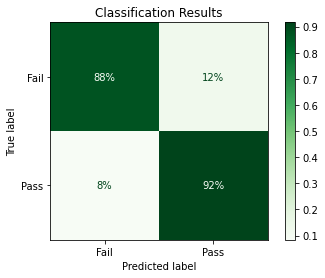

In [4]:
# Split predictors and target
X = student_data.drop('pass', axis=1)
y = student_data['pass']

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# Run SMOTE algorithm on training set
sampler = SMOTE(random_state=2)
X_train_smote, y_train_smote = sampler.fit_sample(X, y)

# Initialize and fit random forest model
rf = RandomForestClassifier(random_state=2)
rf.fit(X_train_smote, y_train_smote)

# Assess accuracy of model on test set
accuracy = rf.score(X_test, y_test)
print('The accuracy of the random forest model is {:.1%}'.format(accuracy))

plot_confusion_matrix(rf, X_test, y_test, normalize='true', display_labels=['Fail', 'Pass'], cmap=plt.cm.Greens, values_format='.0%')
plt.title('Classification Results')
plt.show()